# Regression with ParmEst

In [1]:
from tclab_pyomo import (
    TCLabExperiment,
    create_model,
    extract_results,
    extract_plot_results,
)

## Load and explore experimental data

In [2]:
import pandas as pd

file = '../data/tclab_sine_test.csv'
# file = './data/tclab_step_test.csv'
df = pd.read_csv(file)
df.head()

,Time,T1,T2,Q1,Q2
0,0.00,24.45,24.13,50.0,0.0
1,1.00,24.45,24.13,55.0,0.0
2,2.01,24.45,24.13,60.0,0.0
3,3.01,24.45,24.13,65.0,0.0
4,4.01,24.77,23.81,70.0,0.0


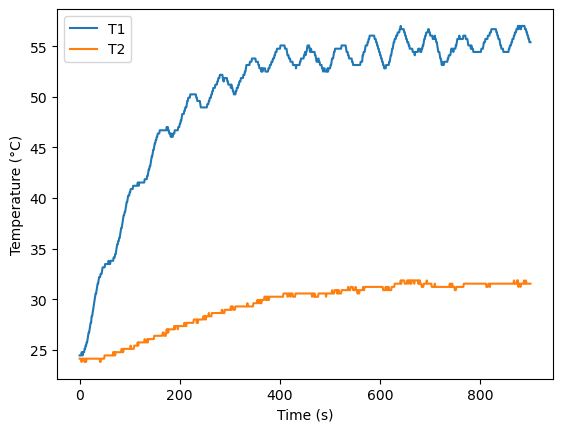

In [3]:
ax = df.plot(x='Time', y=['T1', 'T2'], xlabel='Time (s)', ylabel='Temperature (°C)')

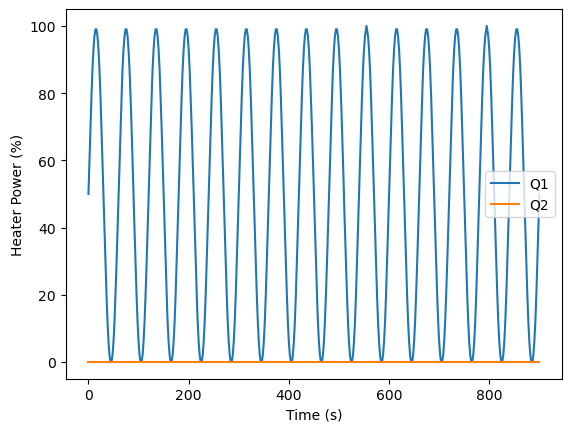

In [4]:
ax = df.plot(x='Time', y=['Q1', 'Q2'], xlabel='Time (s)', ylabel='Heater Power (%)')

## Store in Custom Data Class 

In [5]:
tc_data = TCLabExperiment(
    name="Sine Wave Test for Heater 1",
    time=df['Time'].values,
    T1=df['T1'].values,
    u1=df['Q1'].values,
    P1=200,
    TS1_data=None,
    d1=None,
    T2=df['T2'].values,
    u2=df['Q2'].values,
    P2=200,
    TS2_data=None,
    d2=None,
    Tamb=df['T1'].values[0],
)

In [6]:
tc_data.to_data_frame().head()

,time,T1,u1,P1,TS1_data,d1,T2,u2,P2,TS2_data,d2,Tamb
0,0.00,24.45,50.0,200,None,None,24.13,0.0,200,None,None,24.45
1,1.00,24.45,55.0,200,None,None,24.13,0.0,200,None,None,24.45
2,2.01,24.45,60.0,200,None,None,24.13,0.0,200,None,None,24.45
3,3.01,24.45,65.0,200,None,None,24.13,0.0,200,None,None,24.45
4,4.01,24.77,70.0,200,None,None,23.81,0.0,200,None,None,24.45


## Parameter Estimation in Vanilla Pyomo

In [7]:
from pyomo.environ import SolverFactory

vanilla_regression = create_model(
    data=tc_data.to_data_frame(),
    mode='estimate',
    model_option='parmest',
    integrate_to_initialize=True,
)

# Alternatively, you can use the TCLabExperiment object directly
# vanilla_regression = create_model(data=tc_data, mode='estimate', model_option='parmest', integrate_to_initialize=True)

# Optionally explore the model structure
# vanilla_regression.pprint()

# Solve the regression problem
solver = SolverFactory('ipopt')
results = solver.solve(vanilla_regression, tee=True)

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

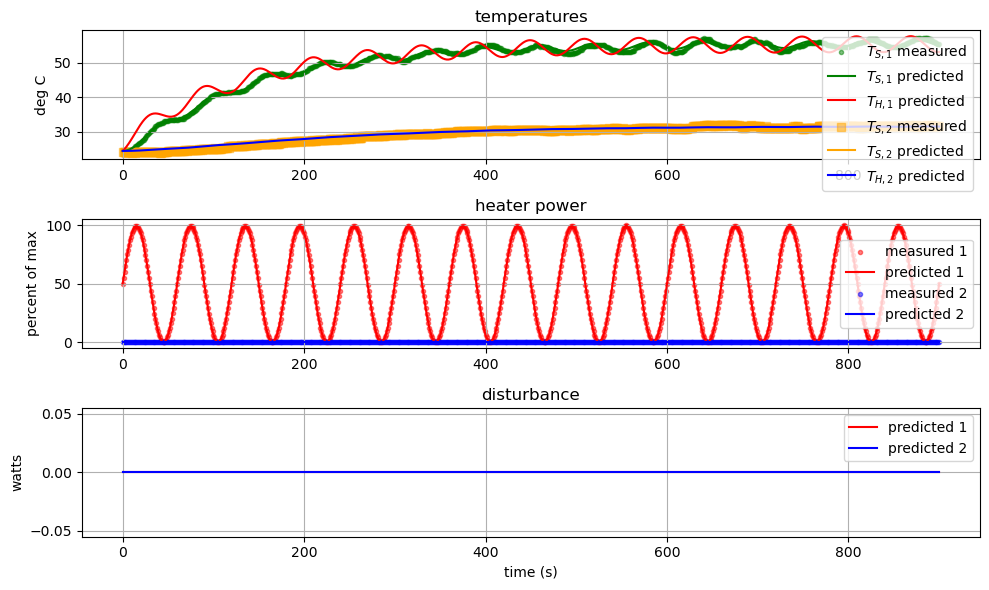

Model parameters:
Ua = 0.0416 Watts/degC
Ub = 0.0005 Watts/degC
Uc = 0.0124 Watts/degC
CpH = 6.5855 Joules/degC
CpS = 0.01 Joules/degC


In [8]:
vanilla_regression_results = extract_plot_results(tc_data, vanilla_regression)

## Parameter Estimation with ParmEst

In [9]:
import pyomo.contrib.parmest.parmest as parmest

# define the parameter names as a list
# theta_names = ['Ua', 'Ub', 'inv_CpH', 'inv_CpS']
theta_names = ['Ua', 'Ub', 'Uc', 'inv_CpH', 'inv_CpS']

parmest_create_model = lambda data: create_model(
    data=data, mode='parmest', model_option='parmest', integrate_to_initialize=True
)

# Create a parameter estimation object
pest = parmest.Estimator(
    parmest_create_model,
    data=[
        tc_data.to_data_frame()
    ],  # Needs to be a list of dataframes, otherwise parmest threats each row as a separate model
    theta_names=theta_names,
    tee=True,
)

obj, theta = pest.theta_est()

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

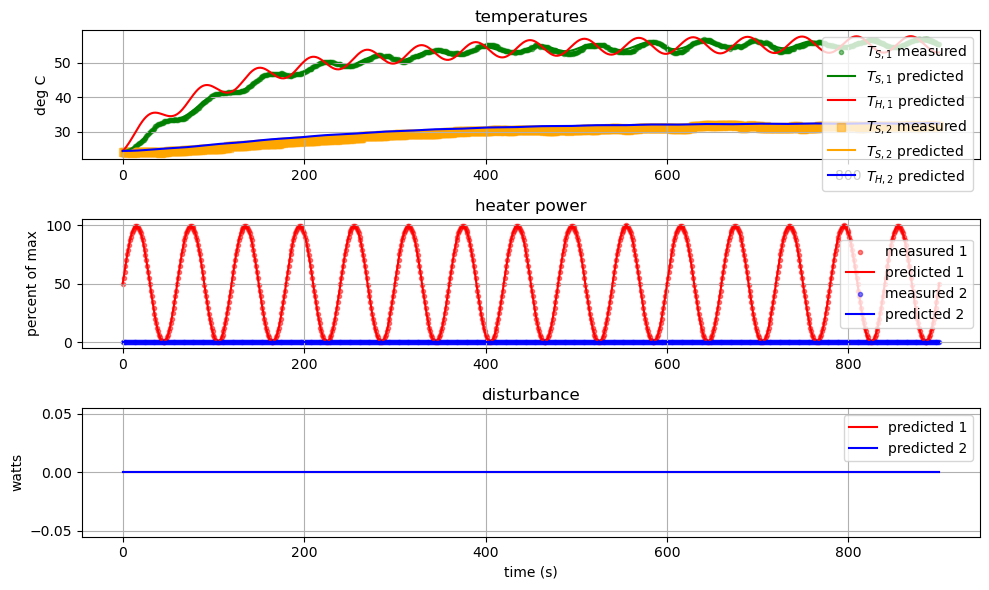

Model parameters:
Ua = 0.0406 Watts/degC
Ub = 0.0005 Watts/degC
Uc = 0.0143 Watts/degC
CpH = 6.3921 Joules/degC
CpS = 0.01 Joules/degC


In [10]:
parmest_regression_results = extract_plot_results(tc_data, pest.parmest_model)

## Covariance Matrix

In [11]:
# Create a parameter estimation object
obj, theta, cov = pest.theta_est(
    calc_cov=True,  # boolean to calculate the covariance matrix
    cov_n=len(tc_data.time),  # number of data points in the least squares objective
)

Ipopt 3.13.2: bound_relax_factor=0
honor_original_bounds=no


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-sca

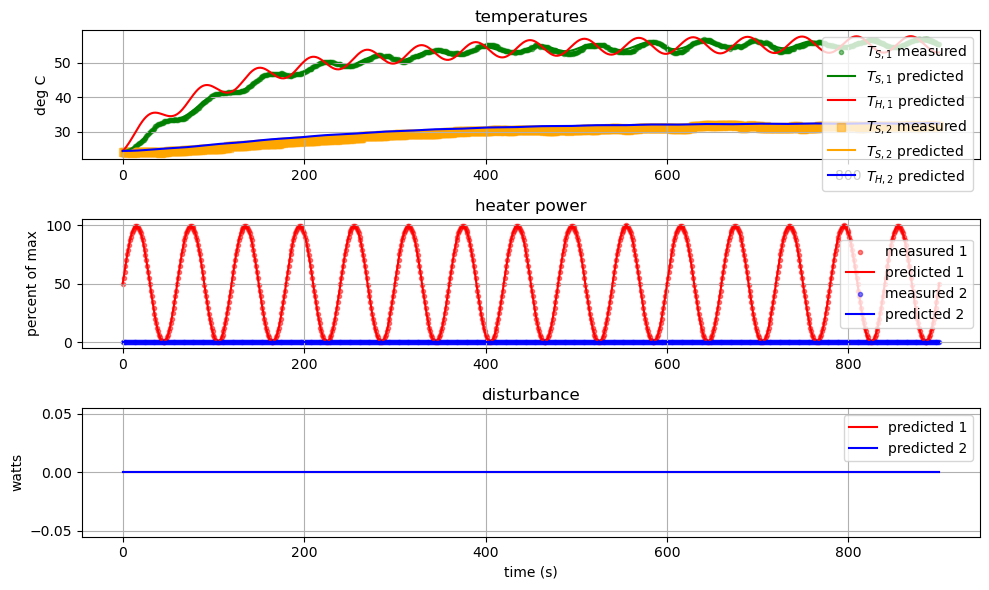

Model parameters:
Ua = 0.0406 Watts/degC
Ub = 0.0005 Watts/degC
Uc = 0.0143 Watts/degC
CpH = 6.3921 Joules/degC
CpS = 0.01 Joules/degC


In [12]:
parmest_regression_results2 = extract_plot_results(tc_data, pest.parmest_model)

In [13]:
print(cov)

                   Ua            Ub            Uc       inv_CpH       inv_CpS
Ua       2.357019e-06  4.208631e-08 -4.425659e-06 -7.332069e-06 -3.291403e-10
Ub       4.208631e-08  9.037926e-10 -7.948886e-08 -1.426415e-07  2.350756e-09
Uc      -4.425659e-06 -7.948886e-08  8.317116e-06  1.383032e-05  6.267151e-10
inv_CpH -7.332069e-06 -1.426415e-07  1.383032e-05  2.405839e-05  2.484327e-09
inv_CpS -3.291403e-10  2.350756e-09  6.267151e-10  2.484327e-09 -4.930056e-04


## Likelihood Ratio Test

In [14]:
if False:
    Ua_vals = [0.03, 0.04, 0.05, 0.06]
    Ub_vals = [0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
    Uc_vals = [0.01, 0.02, 0.03, 0.04]
    inv_CpH_vals = [0.1, 0.2, 0.3, 0.4]
    inv_CpS_vals = [50, 75, 100]

    from itertools import product

    theta_vals = pd.DataFrame(
        list(product(Ua_vals, Ub_vals, Uc_vals, inv_CpH_vals, inv_CpS_vals)),
        columns=theta_names,
    )
    obj_at_theta = pest.objective_at_theta(theta_vals)

    obj_at_theta.to_csv('obj_at_theta.csv')
else:
    obj_at_theta = pd.read_csv('obj_at_theta.csv')

In [16]:
# Run the likelihood ratio test
LR = pest.likelihood_ratio_test(obj_at_theta, obj, [0.8, 0.85, 0.9, 0.95])

# Plot results
parmest.graphics.pairwise_plot(
    LR, theta, 0.9, title="LR results within 90\% confidence region"
)

KeyError: "['Unnamed: 0'] not in index"